# Preprocess

## The following documents are required
- `annotations.json` 
- `metadata_splits.csv` 
- `images/t001/anuJvqUqBB.JPG` ...



In [23]:
import os
import pandas as pd
import json
import shutil
from ultralytics import YOLO
from PIL import Image
import numpy as np
from sklearn.metrics import jaccard_score
import cv2
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import pandas as pd
%matplotlib inline




# You don't need to run the cell's code to process the original dataset, 
# Because the dataset under this project is already processed
# Running without the original dataset will not succeed
```
csv_file = 'metadata_splits.csv' # .csv file used for splitting
metadata_splits = pd.read_csv(csv_file)
metadata_filtered = metadata_splits[['id','file_name','split_open']]

data_types = ['train', 'test', 'valid'] 

train_test_valid_datasets = {} 
for data_type in data_types: 
    train_test_valid_datasets[data_type] = metadata_filtered[metadata_filtered[ 'split_open']==data_type]

annotations_file = 'annotations.json'  # Original annotation file
```
# Reading comment files
```
with open(annotations_file, 'r',encoding='utf-8') as file:
    data = json.load(file)

output_dirs = ['train', 'test', 'valid']
for dir_name in output_dirs:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

for index,row in metadata_filtered.iterrows():
    source_file=row['file_name'] # Original file path
    split =row['split_open']#   (train/test/valid)
    
    destination_folder =split
    destination_path = os.path.join(destination_folder,os.path.basename(source_file))

    if os.path.exists(source_file):
        shutil.move(source_file,destination_path)
        print(f"moved:{source_file}->{destination_path}")
    else:
        print(f"file not exist:{source_file}")
```
# Reading COCO format annotation data
```
annotations_file = 'annotations.json'  
with open(annotations_file, 'r') as f:
    coco_data = json.load(f)

train_ids = set(train_test_valid_datasets['train']['id']) 
valid_ids = set(train_test_valid_datasets['valid']['id']) 
test_ids = set(train_test_valid_datasets['test']['id'])

def split_coco_data(data, ids):
    images = [] 
    for img in data['images']: 
        if img['id'] in ids: 
            img_copy = img.copy() 
            img_copy['file_name'] = f'{os.path.basename(img_copy["file_name"])}' 
            images. append(img_copy)
    annotations = [ann for ann in data['annotations'] if ann['image_id'] in ids]
    split_data = { 
        'info': data['info'], 
        'licenses': data['licenses'], 
        'images': images, 
        'annotations': annotations, 
        'categories': data['categories']
    }
    return split_data

train_data = split_coco_data(coco_data, train_ids) 
valid_data = split_coco_data(coco_data, valid_ids) 
test_data = split_coco_data(coco_data, test_ids) 
```
# Write to Json file
```
with open('annotations/train.json', 'w') as f: 
    json.dump(train_data, f, indent=4) 

with open('annotations/val.json', 'w') as f: 
    json.dump(valid_data, f, indent=4) 

with open('annotations/test.json', 'w') as f: 
    json.dump(test_data, f, indent=4) 

print ("The dataset has been split into train.json, val.json and test.json")
```

# Train

In [2]:
model = YOLO("yolo11n-seg.pt")  # load a pretrained model
# Train the model
# ***modify the path of dataset in  yoloseg.yaml
model.train(data="yoloseg.yaml", epochs=10, imgsz=640, save=True, save_period=5,fraction=0.6)

Ultralytics 8.3.27  Python-3.11.10 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=yoloseg.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.6, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

train: Scanning C:\Users\ljk\COMP9517\Yolo-seg\dataset\labels\train.cache... 3182 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3182/3182 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\ljk\COMP9517\Yolo-seg\dataset\labels\val.cache... 1118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1118/1118 [00:00<?, ?it/s]

val: WARNING  C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\val\gYcjWIRQah.jpg: 1 duplicate labels removed


Plotting labels to runs\segment\train8\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\segment\train8
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.24G     0.8394      1.332      1.624      1.021         71        640: 100%|██████████| 199/199 [00:41<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]


                   all       1118       5378      0.898       0.74      0.805      0.617      0.895      0.728      0.792      0.579

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.06G      0.795        1.1      0.914     0.9829         64        640: 100%|██████████| 199/199 [00:38<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]


                   all       1118       5378      0.924      0.762      0.827       0.62      0.914      0.752      0.813      0.596

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.06G     0.7846      1.051      0.758     0.9755         60        640: 100%|██████████| 199/199 [00:38<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]


                   all       1118       5378      0.899      0.771      0.831      0.644      0.894       0.76      0.817      0.597

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.05G     0.7445      1.008     0.6554     0.9533         60        640: 100%|██████████| 199/199 [00:37<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  4.29it/s]

                   all       1118       5378      0.916      0.788      0.844      0.666      0.909       0.78      0.833      0.632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10         3G     0.6873      0.915     0.5748     0.9344         70        640: 100%|██████████| 199/199 [00:39<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.64it/s]

                   all       1118       5378      0.949      0.819      0.873      0.717      0.941      0.812      0.863      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.01G     0.6489     0.8651     0.5238     0.9171         60        640: 100%|██████████| 199/199 [00:39<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.75it/s]

                   all       1118       5378      0.944      0.825      0.876      0.725      0.937      0.815      0.863       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.99G     0.6161     0.8049     0.4853     0.8979         63        640: 100%|██████████| 199/199 [00:39<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.56it/s]

                   all       1118       5378      0.952      0.834      0.883      0.748      0.954      0.825      0.876      0.697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.99G     0.5849     0.7638     0.4483     0.8884         60        640: 100%|██████████| 199/199 [00:39<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.63it/s]

                   all       1118       5378      0.953      0.847       0.89      0.755      0.948      0.839      0.883      0.697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.01G      0.547     0.7165     0.4182     0.8765         61        640: 100%|██████████| 199/199 [00:40<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.66it/s]

                   all       1118       5378      0.965      0.843      0.893      0.772       0.96      0.838      0.887      0.722



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.99G     0.5243     0.6912     0.3935     0.8657         64        640: 100%|██████████| 199/199 [00:39<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.53it/s]

                   all       1118       5378      0.961       0.85      0.897      0.783      0.963       0.84      0.891      0.729



10 epochs completed in 0.148 hours.
Optimizer stripped from runs\segment\train8\weights\last.pt, 6.0MB
Optimizer stripped from runs\segment\train8\weights\best.pt, 6.0MB

Validating runs\segment\train8\weights\best.pt...
Ultralytics 8.3.27  Python-3.11.10 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,153 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:12<00:00,  2.76it/s]


                   all       1118       5378       0.96       0.85      0.897      0.783      0.963      0.841       0.89      0.729
              carapace       1117       1394      0.991      0.801      0.827      0.792      0.985      0.793      0.818      0.711
               flipper       1105       2892      0.905      0.834      0.896      0.729      0.923      0.823      0.893      0.701
                  head       1086       1092      0.985      0.916      0.968      0.827      0.982      0.906      0.961      0.773
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\segment\train8


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000013153AD6E50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    

# Val

In [3]:
def compare_masks(pred_mask, true_mask):
    """
    Compare the difference between the predicted mask and the true mask and calculate the IoUs for categories 1, 2, and 3, respectively.
    
    parameters:
        pred_mask (np.ndarray): array of predicted masks, shape (height, width).
        true_mask (np.ndarray): array of true masks, shape (height, width).
        
    return:
        IoU outputs for each category.
    """
    print("Unique values in pred_mask:", np.unique(pred_mask))
    print("Unique values in true_mask:", np.unique(true_mask))

    # Expand the array into a one-dimensional vector
    pred_flat = pred_mask.flatten()
    true_flat = true_mask.flatten()

    # Initialize IoU Results Dictionary
    iou_results = {}

    # # IoU in compute categories 1, 2 and 3
    for class_id in [1, 2, 3]:
        # Create binary masks for each category
        pred_class = (pred_flat == class_id).astype(int)
        true_class = (true_flat == class_id).astype(int)

        # Calculate IoU (Jaccard Similarity Factor)
        iou = jaccard_score(true_class, pred_class, average="binary")
        iou_results[class_id] = iou


    return iou_results


image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\ABZIHuoAbI.JPG: 448x640 1 carapace, 2 flippers, 1 head, 14.7ms
Speed: 3.0ms preprocess, 14.7ms inference, 9.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\ABlZjzruvy.JPG: 448x640 1 carapace, 2 flippers, 1 head, 12.4ms
Speed: 3.9ms preprocess, 12.4ms inference, 5.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\AEjzutgwHs.JPG: 448x640 1 carapace, 2 flippers, 1 head, 27.1ms
Speed: 2.6ms preprocess, 27.1ms inference, 5.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\AFPzMoMJhV.jpeg: 448x640 1 carapace, 2 flippers, 1 head, 57.9ms
Speed: 3.9ms preprocess, 57.9ms inference, 7.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\AHxkptpcqw.JPG: 448x640 1 carapace, 2 flippers, 1

D:\SoftWare\Anaconda3\envs\COMP9444PRO\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\BFzonTIUAf.jpeg: 448x640 1 carapace, 2 flippers, 1 head, 5.9ms
Speed: 2.0ms preprocess, 5.9ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\BGAAYrUKQS.JPG: 448x640 1 carapace, 3 flippers, 1 head, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 13.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\BGMXANhrIy.JPG: 448x640 1 carapace, 4 flippers, 1 head, 19.8ms
Speed: 5.0ms preprocess, 19.8ms inference, 15.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\BIlDnYIYsA.jpeg: 448x640 1 carapace, 1 flipper, 1 head, 69.8ms
Speed: 3.1ms preprocess, 69.8ms inference, 18.2ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\BJeJrlETnH.JPG: 448x640 1 carapace, 1 flipper, 1

D:\SoftWare\Anaconda3\envs\COMP9444PRO\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\BtAGMOznuw.jpeg: 448x640 1 carapace, 2 flippers, 1 head, 64.1ms
Speed: 5.1ms preprocess, 64.1ms inference, 24.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\BtBeiFEJOa.JPG: 448x640 1 carapace, 2 flippers, 1 head, 17.8ms
Speed: 3.3ms preprocess, 17.8ms inference, 14.2ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\BtHpROAFUA.jpeg: 448x640 1 carapace, 2 flippers, 1 head, 49.1ms
Speed: 4.2ms preprocess, 49.1ms inference, 36.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\ByfSjvYayg.jpeg: 448x640 2 carapaces, 3 flippers, 1 head, 18.0ms
Speed: 2.8ms preprocess, 18.0ms inference, 17.2ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\BzrPfMNqDl.jpeg: 448x640 1 carapace, 2 fli

<Figure size 800x600 with 0 Axes>

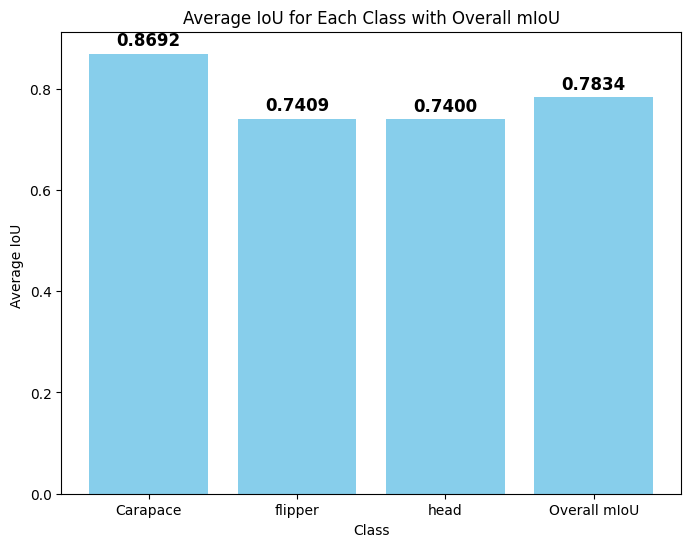

In [25]:
# load a saved model in "runs/segment/"
model = YOLO("runs/segment/train8/weights/best.pt")

# Define image and mask directory paths
image_dir = "/Users/ljk/COMP9517/Yolo-seg/dataset/images/test/"
mask_dir = image_dir.replace("images", "masks")

# Get a list of image files, select 10%
image_files = sorted(os.listdir(image_dir))
image_files = image_files[:len(image_files)  // 10]  #  10%

# Initialize variables to accumulate IoUs and counts for each category
iou_sums = {1: 0, 2: 0, 3: 0}
count_sums = {1: 0, 2: 0, 3: 0}

# Define the function that calculates the IoU
def calculate_iou(pred_mask, true_mask, class_id):
    # Converting masks to binary masks
    pred_binary = (pred_mask == class_id).astype(int)
    true_binary = (true_mask == class_id).astype(int)
    # Computing IoU
    return jaccard_score(true_binary.flatten(), pred_binary.flatten(), average="binary")

# Val
# Iterate over the image and calculate the IoU
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, os.path.splitext(image_file)[0] + ".png")

    
    results = model(image_path)
    
    # Extract Prediction Mask
    for img in results:
        if img.masks is not None:
            # Convert to NumPy Array
            pred_masks = img.masks.data.float().cpu().numpy()  # (num_instances, height, width)
            class_ids = img.boxes.cls.cpu().numpy()  # categories

            # Replace non-zero pixels in each instance mask with category values
            for i, (mask, class_id) in enumerate(zip(pred_masks, class_ids)):
                mask[mask > 0] = int(class_id + 1)

            # Merge all instance masks
            combined_mask = np.zeros(pred_masks.shape[1:], dtype=np.float32)
            for mask in pred_masks:
                combined_mask = np.maximum(combined_mask, mask)

        else:
            print("No masks detected.")
            combined_mask = None

        # Load True Mask
        if os.path.exists(mask_path):
            true_mask = Image.open(mask_path).convert("L")
            true_mask = np.array(true_mask)

            # Resize the predicted mask to the size of the true mask
            if combined_mask is not None:
                combined_mask = cv2.resize(combined_mask, (true_mask.shape[1], true_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
                # Calculate each category's IoU
                for class_id in [1, 2, 3]:
                    iou = calculate_iou(combined_mask, true_mask, class_id)
                    iou_sums[class_id] += iou
                    count_sums[class_id] += 1
        else:
            print(f"Real mask not found for {image_file}.")
            

    # Calculate the average IoU for each category 
average_ious = {class_id: iou_sums[class_id] / count_sums[class_id] for class_id in iou_sums}
average_iou_values = list(average_ious.values())
overall_mean_iou = sum(average_iou_values) / len(average_iou_values)  # 计算总体平均 mIoU
class_labels= ["Carapace", "flipper", "head", "Overall mIoU"]

# Adding overall average mIoU to the data
average_iou_values.append(overall_mean_iou)

# Converting IoU values to percentages
average_iou_values_percentage = [v  for v in average_iou_values]

# Plotting bar charts
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(class_labels, average_iou_values_percentage, color='skyblue')

ax.bar_label(bars, labels=[f"{v:.4f}" for v in average_iou_values_percentage], padding=3, fontsize=12, color='black', fontweight='bold')

ax.set_xlabel("Class")
ax.set_ylabel("Average IoU ")
ax.set_title("Average IoU for Each Class with Overall mIoU")

out_dir = os.path.join(os.path.dirname(image_path).replace("dataset/images/test", "out"))
os.makedirs(out_dir, exist_ok=True)

# Save the image to the specified folder with the file name “Yolo_TurtleData_mIoU.png”
plt.savefig(os.path.join(out_dir, "Yolo_TurtleData_mIoU.png"))
plt.show(block=True)




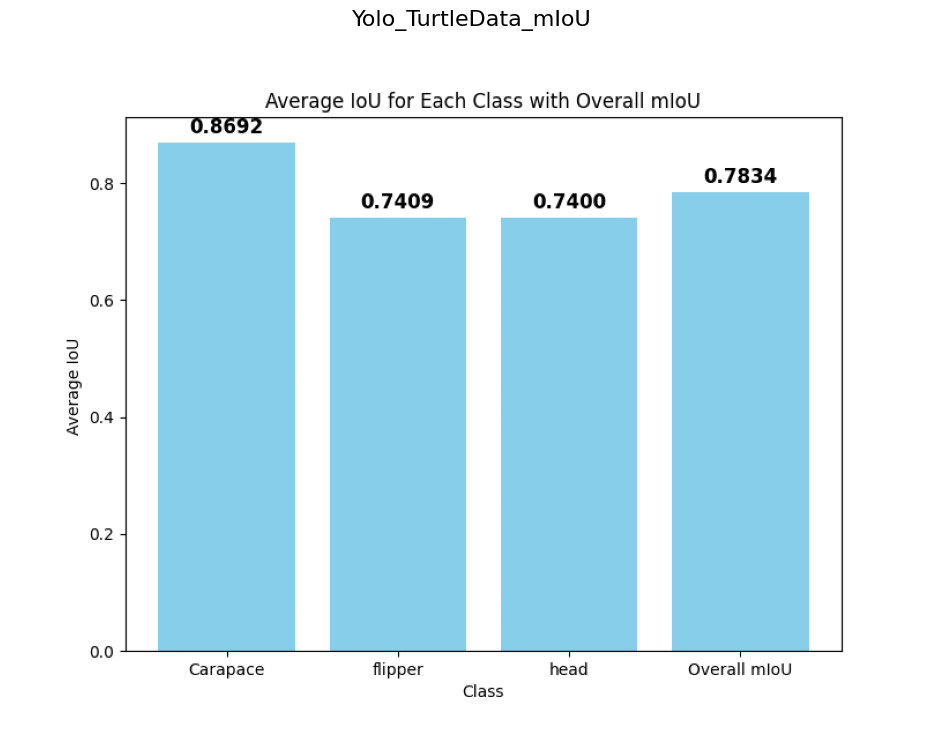

In [26]:
miou_path = r"out\Yolo_TurtleData_mIoU.png"
if os.path.exists(miou_path):
    # Load and display the image
    img = plt.imread(miou_path)
    plt.figure(figsize=(12, 9))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better visualization
    plt.title("Yolo_TurtleData_mIoU", fontsize=16)
    plt.show()
else:
    print(f"File not found at the specified path: {miou_path}")

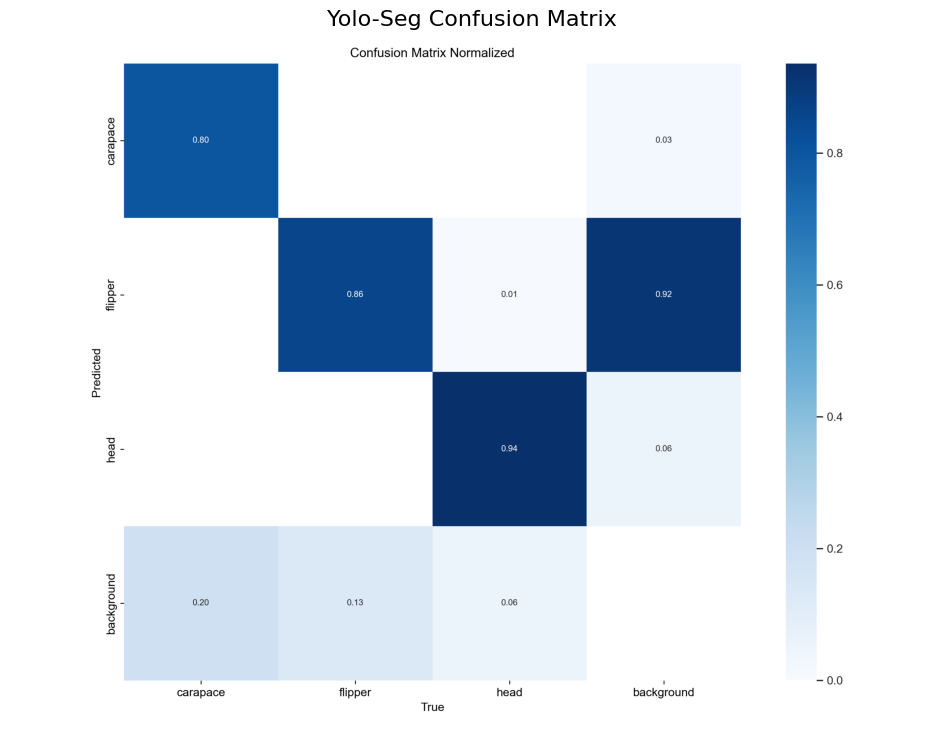

In [9]:
confusion_matrix_path = r"runs\\segment\\train8\\confusion_matrix_normalized.png"

# Check if the file exists
if os.path.exists(confusion_matrix_path):
    # Load and display the image
    img = plt.imread(confusion_matrix_path)
    plt.figure(figsize=(12, 9))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better visualization
    plt.title("Yolo-Seg Confusion Matrix", fontsize=16)
    plt.show()
else:
    print(f"File not found at the specified path: {confusion_matrix_path}")

# Predict


image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\aAFboMSSvO.jpeg: 448x640 1 carapace, 2 flippers, 1 head, 210.7ms
Speed: 2735.1ms preprocess, 210.7ms inference, 55.0ms postprocess per image at shape (1, 3, 448, 640)


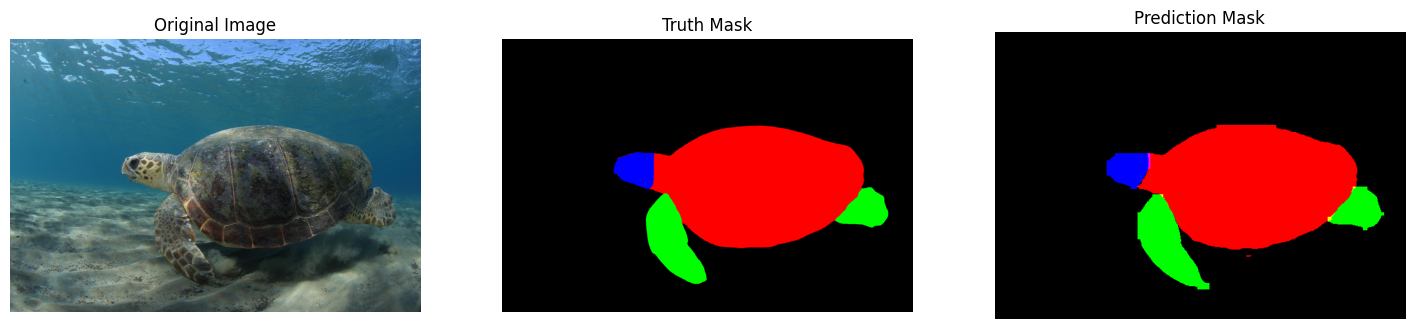


image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\AaiPbPQCZB.JPG: 448x640 1 carapace, 4 flippers, 7.4ms
Speed: 6.0ms preprocess, 7.4ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)


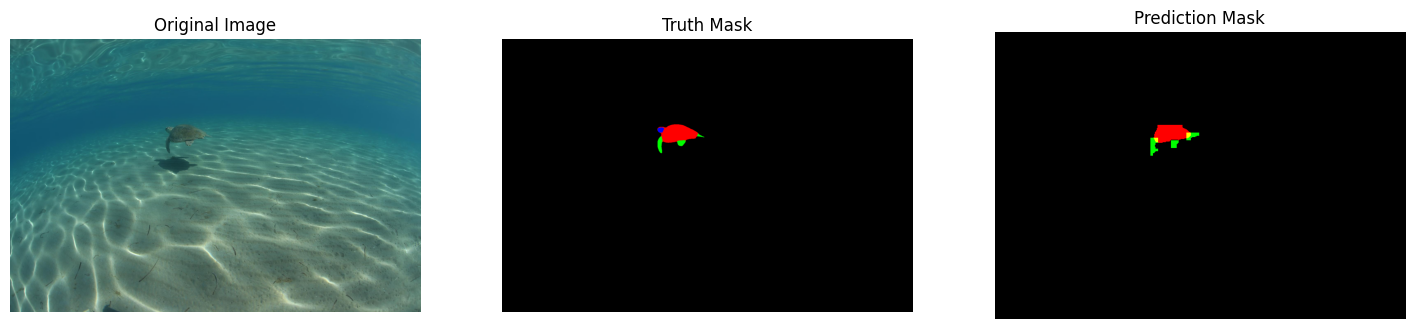


image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\aalmdYvRDo.jpeg: 448x640 1 carapace, 5 flippers, 1 head, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)


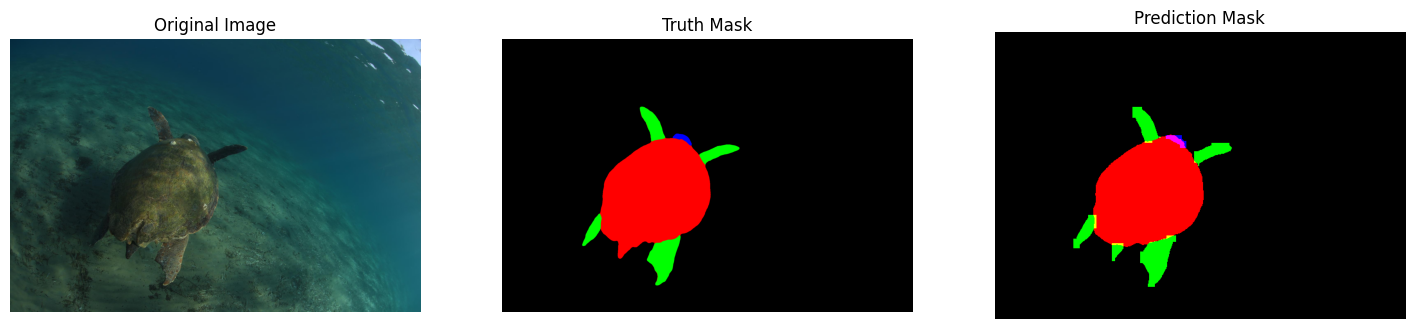


image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\aBHFUlgmqd.JPG: 448x640 1 carapace, 3 flippers, 1 head, 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 13.8ms postprocess per image at shape (1, 3, 448, 640)


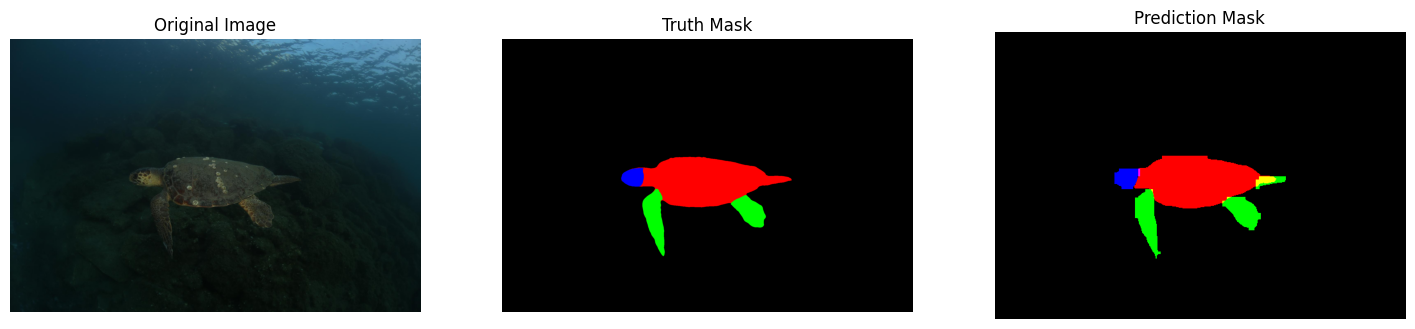


image 1/1 C:\Users\ljk\COMP9517\Yolo-seg\dataset\images\test\ABlZjzruvy.JPG: 448x640 1 carapace, 2 flippers, 1 head, 13.4ms
Speed: 2.9ms preprocess, 13.4ms inference, 9.9ms postprocess per image at shape (1, 3, 448, 640)


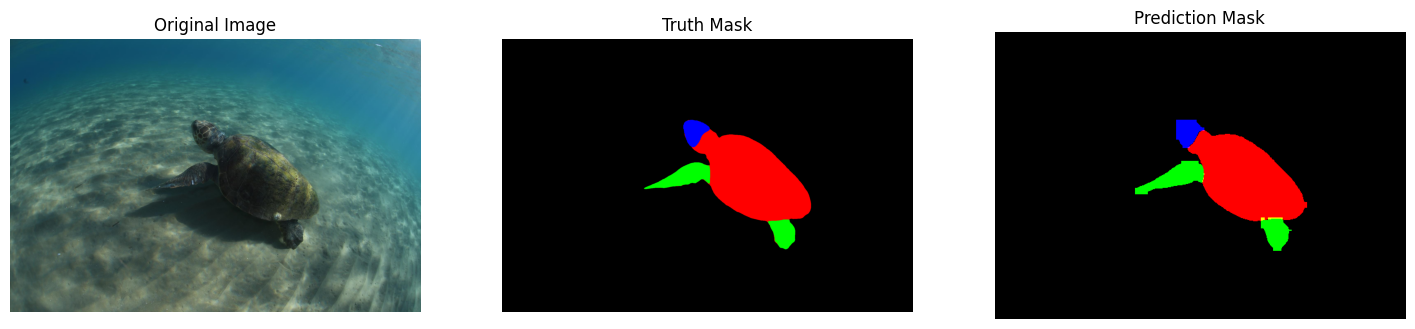

In [24]:
# 自定义类别颜色映射
colors = {
    0: (255, 0, 0),     # 类别0，红色
    1: (0, 255, 0),     # 类别1，绿色
    2: (0, 0, 255),     # 类别2，蓝色
    3: (0, 0, 0),       # 背景，黑色
}

image_dir = "dataset/images/test/"
mask_dir  = "dataset/masks/test/"
image_files = os.listdir(image_dir)
image_files = image_files[1:6]  

# 处理每张图片
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, os.path.splitext(image_file)[0] + ".png")
    results = model(image_path)  # 获取预测结果

    # 加载原图
    original_image = Image.open(image_path).convert("RGB")

    # 加载原图的真实掩码
    if os.path.exists(mask_path):
        true_mask = Image.open(mask_path).convert("L")
        true_mask = np.array(true_mask)
        true_mask_colored = np.zeros((*true_mask.shape, 3), dtype=np.uint8)

        # 使用颜色映射生成彩色真实掩码
        for class_id, color in colors.items():
            true_mask_colored[true_mask == class_id+1] = color
    else:
        print(f"No ground truth mask found for {image_file}.")
        true_mask_colored = np.zeros((original_image.height, original_image.width, 3), dtype=np.uint8)

    # 处理预测结果
    if results[0].masks is not None:
        # 获取掩码和类别信息
        pred_masks = results[0].masks.data.cpu().numpy()  # (num_instances, height, width)
        class_ids = results[0].boxes.cls.cpu().numpy().astype(int)  # 类别索引

        # 初始化彩色预测结果图像
        height, width = pred_masks.shape[1:]
        colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

        # 遍历每个实例掩码并上色（只处理类别0, 1, 2）
        for mask, class_id in zip(pred_masks, class_ids):
            if class_id in colors:  # 只处理定义的类别
                mask = (mask > 0).astype(np.uint8)  # 转为二值掩码
                for c in range(3):  # 应用颜色
                    colored_mask[..., c] += (mask * colors[class_id][c])
    else:
        print(f"No masks detected for {image_file}.")
        colored_mask = np.zeros((original_image.height, original_image.width, 3), dtype=np.uint8)

    # 可视化：原图、真实掩码、预测结果
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original_image)
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    axes[1].imshow(true_mask_colored)
    axes[1].axis("off")
    axes[1].set_title("Truth Mask")

    axes[2].imshow(colored_mask)
    axes[2].axis("off")
    axes[2].set_title("Prediction Mask")

    # 保存结果
    save_path = os.path.join(out_dir, f"compare_{os.path.splitext(image_file)[0]}.png")
    plt.savefig(save_path)
    plt.show()